# Trao An Huy 22280041  Global Vectors for Word Representation

# Prepare corpus

In [8]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
!unzip text8.zip

--2025-04-18 15:32:47--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.139.240, 52.216.213.72, 52.216.217.240, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.139.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip.1’

text8.zip.1         100%[===================>]  29.89M  8.62MB/s    in 3.5s    

2025-04-18 15:32:51 (8.62 MB/s) - ‘text8.zip.1’ saved [31344016/31344016]

Archive:  text8.zip
replace text8? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: text8                   


In [9]:
with open("text8", encoding="utf-8") as f:
    corpus = f.read()

In [10]:
len(corpus)

100000000

In [11]:
# Print the first 1e5 letters
corpus = corpus[:100000]
corpus

' anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philosophy is the belief that rulers are unnecessary and should be abolished although there are differing interpretations of what this means anarchism also refers to related social movements that advocate the elimination of authoritarian institutions particularly the state the word anarchy as most anarchists use it does not imply chaos nihilism or anomie but rather a harmonious anti authoritarian society in place of what are regarded as authoritarian political structures and coercive economic institut

# Global vector (GloVe)
- GloVe was first introduced by [Pennington et al., 2014](https://nlp.stanford.edu/pubs/glove.pdf)
- Previously, there were two main directions for learning distributed word representations:
    1. Count-based methods such as Latent Semantic Analysis (LSA)
    2. Direct prediction-based methods such as Word2Vec.

Count-based methods make efficient use of statistical information about the corpus, but they do not capture the meaning of the words like word2vec and perform poorly on analogy tasks such as _**“king - queen = man - woman”**_. On the other hand, direct prediction-based methods capture the meaning of the word semantically and syntactically using local context but fail to consider the global count statistics. This is where GloVe comes into the picture and overcomes the drawbacks of both approaches by combining them. The author proposed a global log bilinear regression model to learn embeddings based on the co-occurrence of words.

## Co-occurrence matrix

Consider a corpus:
- I like deep learning
- I like NLP
- I enjoy flying

GloVe uses a co-occurrence matrix with a context window of fixed size $m$ to learn the word embeddings. The example co-occurrence matrix for the aforegiven corpus with a **context window of size $m=2$**:
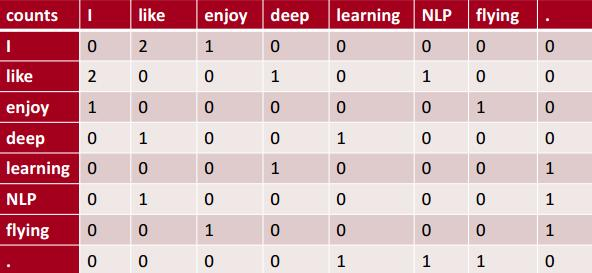






## Mathematical foundation

Denote:
- $X$ as the word-word co-occurrence matrix
- $X_{ij}$ as the number of times word $j$ occurs in the context of word $i$
- $X_i$ = $\sum_{k}{X_{ik}}$ as the number of times any word $k$ appearing in context of word $i$ and $k$ represents the total number of distinct words that appear in context of word $i$)
- $P_{ij} = P(j | i) = \frac{X_{ij}}{X_i}$ as the co-occurence probablity i.e. probability that word $j$ appears in the context of word $i$

The denominator term in the co-occurrence probability accounts for global statistics, which word2vec does not uses. The main idea behind the GloVe is to encode meaning using the ratios of co-occurrence probabilities. Let's understand the above by deriving the linear meaning components for the following words based on co-occurrence probability.

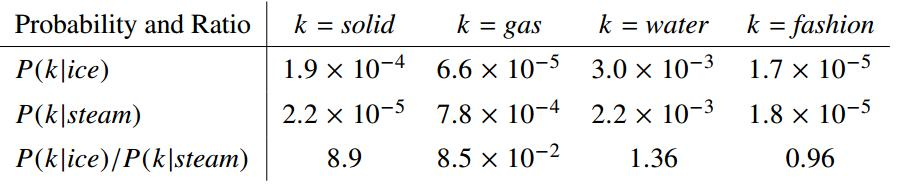

The matrix shows the co-occurrence probabilities for the words from the concept of the thermodynamic phases of water (i.e., $ice$ and $steam$). The first two rows represent the co-occurrence probabilities for the words $ice$ and $steam$, whereas the last row represents their ratios. We can observe the following:
- ratio is not neural for closely related words such as $solid$ and $ice$ or $gas$ and $steam$
- ratio is neutral for words relevant to $ice$ and $steam$ both or not completely irrelevant to both

The ratio of co-occurrence proababilities is a good starting point for learning word embeddings. Let's start with the most general function $F$ parametrized by 3 word vectors ($w_i$, $w_j$ and $\tilde{w_k}$) given below:

$$
F(w_i, w_j, \tilde{w_k}) = \frac{P_{ik}}{P_{jk}}
$$

where $w, \tilde{w} \in \mathrm{R^d}$ and $\tilde{w}$ represent the separate context words.

How do we choose $F$?

There can be many possibilities for choosing $F$ but imposing some constraints allows us to restrict $F$ and select a unique choice. The goal is to learn word vectors (embeddings) that can be projected in the word vector space. These vector spaces are inherently linear, i.e., think of vectors as a line in $\mathrm{R^d}$ space, so the most intuitive way is to take vector differences which makes our function $F$ as follows:

$$
F(w_i - w_j, \tilde{w_k}) = \frac{P_{ik}}{P_{jk}}
$$

We see that the right-hand side of the above equation is a scalar. Choosing a complex function such as a neural network would introduce non-linearities since our primary goal is to capture the linear meaning components from word vector space. Here, we take dot product on the left-hand side to make it a scalar similar to the right-hand side.

$$
F((w_i - w_j)^T \tilde{w_k}) = \frac{P_{ik}}{P_{jk}}
$$

We also need to preserve symmetry for the distinction between a word and a context word which means that if $ice$ can be used as a context word for $water$, then $water$ can also be used as a context word for $ice$. In a simple, it can be expressed as $w \leftrightarrow \tilde{w}$. This is also evident from our co-occurrence matrix since $X \leftrightarrow X^T$. In order to restore the symmetry, we require that function $F$ is a homomorphism between groups $(\mathrm{R, +})$ and $(\mathrm{R, \times})$.

> _Given two groups, $\small (G, ∗)$ and $\small (H, \cdot)$, a group homomorphism from $\small (G, ∗)$ to $\small (H, \cdot)$ is a function $\small h : G \rightarrow H$ such that for all $u$ and $v$ in $\small G$ it holds that $\small h(u * v) = h(u) \cdot h(v)$_

$$
\begin{align}
F((w_i - w_j)^T \tilde{w_k}) &= F(w_i^T \tilde{w_k} + (-w_j^T \tilde{w_k})) \\
                            &= F(w_i^T \tilde{w_k}) \times F(-w_j^T \tilde{w_k}) \\
                            &= F(w_i^T \tilde{w_k}) \times F(w_j^T \tilde{w_k})^{-1} \\
                            &= \frac{F(w_i^T \tilde{w_k})}{F(w_j^T \tilde{w_k})} \\
\end{align}
$$

So if we recall the $F$ in terms of co-occurrence probabilities, we get the following:

$$
F(w_i^T \tilde{w_k}) = P_{ik} = \frac{X_{ik}}{X_i}
$$

Since we are expressing $F$ in terms of probability which is a non-negative term, so we apply exponential to dot product $w_i^T \tilde{w_k}$ and then take logarithm on both sides.

$$
w_i^T \tilde{w_k} = log(P_{ik}) = log(X_{ik}) - log(X_i)
$$

On the right hand, the term $log(X_i)$ is independent of $k$ so it can be absorbed into a bias $b_i$ for $w_i$. Finally, we add bias $\tilde{b_k}$ for $\tilde{w_k}$ to restore the symmetry.

$$
w_i^T \tilde{w_k} + b_i + \tilde{b_k} = log(X_{ik})
$$

The above equation leads to our objective function, a weighted least squares regression model where we use the weighting function $f(X_{ij})$ for word-word co-occurrences.

$$
J = \sum_{i,j = 1}^{V}f(X_{ij}) (w_i^T \tilde{w_k} + b_i + \tilde{b_k} - logX_{ik})^2
$$

where $V$ is the size of the vocabulary.

Here, the weighting function is defined as follows:

$$
f(x) = \begin{cases}
        (x / x_{max})^{\alpha} & \text{if}\ x < x_{max} \\
        1 & \text{otherwise}
       \end{cases}
$$

where $x_{max}$ is the cutoff of the weighting function and $\alpha$ is power scaling similar to Word2Vec.


## Implementation

In [12]:
import numpy as np
from collections import Counter, defaultdict

import torch
from torch import nn

### Model

In [31]:
class GloVeModel(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 embed_dim: int,
                 x_max: int = 100,
                 alpha: int = 0.7) -> None:
        """
        Constructor

        Args:
        vocab_size (int) -- Number of words in the vocabulary set
        embed_dim (int) -- Embeddings of dimension to be mapped into
        x_max (int) -- Cut-off of the weighting function
        alpha (int) -- Parameter of the weighting function
        """

        super().__init__()

        # Initialize constructor variable
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.x_max = x_max
        self.alpha = alpha

        # Construct embedding layer
        ### START YOUR CODE HERE ###
        """
        Your task is to config 4 embedding layers:
        input_embedding_layer -- Embedding layer with input features = vocab_size and output features = embed_dim
        input_bias_layer -- Embedding layer with input features = vocab_size and output features = 1

        output_embedding_layer-- Embedding layer with input features = vocab_size and output features = embed_dim
        output_bias_layer -- Embedding layer with input features = vocab_size and output features = 1
        """

        self.input_embedding_layer = nn.Embedding(vocab_size, embed_dim)
        self.input_bias_layer = nn.Embedding(vocab_size, 1)

        self.output_embedding_layer = nn.Embedding(vocab_size, embed_dim)
        self.output_bias_layer = nn.Embedding(vocab_size, 1)

        """
        Initialize input_embedding_layer and output_embedding_layer with xavier intialization method
        """
        nn.init.xavier_normal_(self.input_embedding_layer.weight)
        nn.init.xavier_normal_(self.output_embedding_layer.weight)

        # Initialize 2 bias layers with zero initialization
        self.input_bias_layer.weight.data.zero_()
        self.output_bias_layer.weight.data.zero_()

        ### END YOUR CODE HERE ###

    def forward(self,
                input_ids,
                output_ids,
                cooccurrence_counts) -> torch.Tensor:
        """
        Forward passing
        """

        input_embedding = self.input_embedding_layer(input_ids)
        input_bias = self.input_bias_layer(input_ids)

        output_embedding = self.output_embedding_layer(output_ids)
        output_bias = self.output_bias_layer(output_ids)

        # Avoid $log(0)$
        cooccurrence_counts += 1

        # Count weight factor
        weight_factor = torch.pow(cooccurrence_counts / self.x_max, self.alpha)

        # Calculate the distance between the input and output embeddings
        embedding_products = torch.sum(input_embedding * output_embedding, dim=1)
        log_cooccurrences = torch.log(cooccurrence_counts)
        distances = (embedding_products + input_bias + output_bias - log_cooccurrences) ** 2

        return torch.mean(weight_factor * distances)

## Training

In [29]:
class GloVeDataset(object):
    def __init__(self,
                 corpus,
                 min_count=5,
                 window_size=5) -> None:
        """
        Prepares the training data for the glove model.

        Args:
        corpus (string): corpus of words
        min_count (int): words with minimum occurrence to consider
        window_size (int): context window size for generating co-occurrence matrix
        """
        self.window_size = window_size
        self.min_count = min_count

        tokens = corpus.split(" ")
        word_counts = Counter(tokens)

        # Only consider the words that occur more than 5 times in the corpus
        word_counts = Counter({word:count for word, count in word_counts.items() if count >= min_count})

        self.word2idx = {word: idx for idx, (word, _) in enumerate(word_counts.most_common())}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        # Create the training corpus
        self.token_ids = [self.word2idx[word] for word in tokens if word in self.word2idx]

        # Create the co-occurrence matrix for corpus
        self.create_cooccurrence_matrix()

    def create_cooccurrence_matrix(self):
        """
        Creates the co-occurence matrix of center and context words based on the context window size.
        """
        cooccurrence_counts = defaultdict(Counter)
        for current_idx, word in enumerate(self.token_ids):
            # Find the start and end of context window
            left_boundary = max(current_idx - self.window_size, 0)
            right_boundary = min(current_idx + self.window_size + 1, len(self.token_ids))

            # Obtain the context words and center words based on context window
            context_word_ids = self.token_ids[left_boundary:current_idx] + self.token_ids[current_idx + 1:right_boundary]
            center_word_id = self.token_ids[current_idx]

            for idx, context_word_id in enumerate(context_word_ids):
                if current_idx != idx:
                    # Add (1 / distance from center word) for this pair
                    cooccurrence_counts[center_word_id][context_word_id] += 1 / abs(current_idx - idx)

        # Create tensors for input word ids, output word ids and their co-occurence count
        in_ids, out_ids, counts = [], [], []
        for center_word_id, counter in cooccurrence_counts.items():
            for context_word_id, count in counter.items():
                in_ids.append(center_word_id)
                out_ids.append(context_word_id)
                counts.append(count)

        self.in_ids = torch.tensor(in_ids, dtype=torch.long)
        self.out_ids = torch.tensor(out_ids, dtype=torch.long)
        self.cooccurrence_counts = torch.tensor(counts, dtype=torch.float)


    def get_batches(self, batch_size):
        """
        Creates the batches for training the network.

        Args:
        batch_size (int): size of the batch

        Returns:
        batch (torch tensor of shape (batch_size, 3)): tensor of word pair ids and co-occurence counts for a given batch
        """
        random_ids = torch.tensor(np.random.choice(len(self.in_ids), len(self.in_ids), replace=False), dtype=torch.long)

        for i in range(0, len(random_ids), batch_size):
            batch_ids = random_ids[i: i+batch_size]
            yield self.in_ids[batch_ids], self.out_ids[batch_ids], self.cooccurrence_counts[batch_ids]

In [15]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [16]:
# Change corpus into the correct format for GloVe
dataset = GloVeDataset(corpus)

#**Problem**

In [ ]:
"""
Within this part, you would intialize hyperparameters for the training procedure.

You shall set up these following hyperparameters:
- Vocab size (int) -- You shall decide which vocab size is suitable based on the aforegiven dataset
- Embeddeding dimension (int) -- You shall test and point out which embedding dimension is best suit
- Learning rate (float) -- Learning rate for optimization algorithm
- Optimizer (torch.optim) -- Optimization algorithm for model training
- Number of epochs (int) -- Number of epochs for model to learn
- Batch size (int) -- Dataset batch size

"""

# Problem Cell 1: Hyperparameter Setup
#========================================

### START YOUR CODE HERE ###

# --- Hyperparameters ---
# Get vocab size from the dataset object (words with min_count occurrences)
vocab_size = len(dataset.word2idx)
print("vocab_size")
print(vocab_size)

# Embedding dimension - Smaller might be better for tiny dataset
embed_dim = 50

# Learning rate for Adam optimizer
learning_rate = 0.0005
# Number of training epochs - May need more for convergence on small data
epochs = 300

# Batch size - Smaller might be more stable on small/sparse data
batch_size = 256

# Parameters for the weighting function f(x) - Standard GloVe values
x_max = 100
alpha = 0.75

# --- Model Initialization ---
# Create the GloVe model instance
model = GloVeModel(vocab_size=vocab_size,
                   embed_dim=embed_dim,
                   x_max=x_max,
                   alpha=alpha)
# Move the model to the appropriate device (GPU or CPU)
model.to(device)

# --- Optimizer ---
# Use Adam optimizer, common for NLP tasks
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f"Vocabulary Size: {vocab_size}")
print(f"Embedding Dimension: {embed_dim}")
print(f"Learning Rate: {learning_rate}")
print(f"Epochs: {epochs}")
print(f"Batch Size: {batch_size}")
print(f"Using device: {device}")

### END YOUR CODE HERE ####

vocab_size
524
Vocabulary Size: 524
Embedding Dimension: 50
Learning Rate: 0.0005
Epochs: 300
Batch Size: 256
Using device: cuda


In [49]:
"""
Your task is to construct a training pipeline for GloVe model and the aforegiven DataLoader

The pipeline consists of several steps:
- Iterate through every epoch
- Within each epoch:
    - Query input word, target word and cooccurrence counts in the dataloader for each batch size
    - Load input word, target word, coocurrence counts into GPU device using .to(device) attribute
    - Forward passing data to model
    - Calculate loss
    - Clear optimizer accumulating gradient
    - Backpropagation
    - Upgrade model weight by optimization algorithm
"""

### START YOUR CODE HERE ###

print("\n--- Starting Training ---")
for epoch in range(epochs):
    total_loss = 0.0
    num_batches = 0

    # Get batches from the dataset
    for i, (input_word_ids, target_word_ids, cooccurrence_val) in enumerate(dataset.get_batches(batch_size)):
        # Move batch data to the selected device
        input_word_ids = input_word_ids.to(device)
        target_word_ids = target_word_ids.to(device)
        cooccurrence_val = cooccurrence_val.to(device)

        # --- Forward Pass ---
        # The model's forward method calculates and returns the loss directly
        # based on the GloVe objective function
        loss = model(input_word_ids, target_word_ids, cooccurrence_val)

        # --- Backward Pass and Optimization ---
        # 1. Clear previous gradients
        optimizer.zero_grad()

        # 2. Calculate gradients of the loss w.r.t. model parameters
        loss.backward()

        # 3. Update model parameters using the optimizer
        optimizer.step()

        # Accumulate loss
        total_loss += loss.item()  # Use .item() to get the Python number from the tensor
        num_batches += 1

    # Calculate and print average loss for the epoch
    avg_loss = total_loss / num_batches if num_batches > 0 else float('nan')
    print(f"Epoch: {epoch+1}/{epochs}, Average Loss: {avg_loss:.10f}")

print("\n--- Training Finished ---")

# Get the final embeddings
# Typically, GloVe final embeddings are the sum or average of input and output embeddings
input_embeddings = model.input_embedding_layer.weight.data.cpu().numpy()
output_embeddings = model.output_embedding_layer.weight.data.cpu().numpy()
final_embeddings = (input_embeddings + output_embeddings) / 2  # Average is often used

### END YOUR CODE HERE ####



--- Starting Training ---
Epoch: 1/300, Average Loss: 0.0000401569
Epoch: 2/300, Average Loss: 0.0000310751
Epoch: 3/300, Average Loss: 0.0000265558
Epoch: 4/300, Average Loss: 0.0000234431
Epoch: 5/300, Average Loss: 0.0000206994
Epoch: 6/300, Average Loss: 0.0000179212
Epoch: 7/300, Average Loss: 0.0000150652
Epoch: 8/300, Average Loss: 0.0000123496
Epoch: 9/300, Average Loss: 0.0000099604
Epoch: 10/300, Average Loss: 0.0000080866
Epoch: 11/300, Average Loss: 0.0000066214
Epoch: 12/300, Average Loss: 0.0000054859
Epoch: 13/300, Average Loss: 0.0000045972
Epoch: 14/300, Average Loss: 0.0000038667
Epoch: 15/300, Average Loss: 0.0000033103
Epoch: 16/300, Average Loss: 0.0000027484
Epoch: 17/300, Average Loss: 0.0000023002
Epoch: 18/300, Average Loss: 0.0000019387
Epoch: 19/300, Average Loss: 0.0000016330
Epoch: 20/300, Average Loss: 0.0000013907
Epoch: 21/300, Average Loss: 0.0000012057
Epoch: 22/300, Average Loss: 0.0000010642
Epoch: 23/300, Average Loss: 0.0000009555
Epoch: 24/300, A

In [50]:

# see a layer.
model.eval()


GloVeModel(
  (input_embedding_layer): Embedding(524, 50)
  (input_bias_layer): Embedding(524, 1)
  (output_embedding_layer): Embedding(524, 50)
  (output_bias_layer): Embedding(524, 1)
)

In [ ]:
def get_glove_embedding(word: str) -> np.ndarray | None:
    """
    Returns the GloVe embedding vector for a given word.

    Args:
        word (str): The input word.

    Returns:
        np.ndarray | None: The embedding vector as a NumPy array,
        or None if the word is not in the vocabulary.
    """
    # Look up the word index from the vocabulary
    word_index = dataset.word2idx.get(word)
    if word_index is None:
        print(f"'{word}' not found in the vocabulary.")
        return None

    # Convert the index to a tensor and move it to the appropriate device
    word_tensor = torch.tensor([word_index], dtype=torch.long).to(device)

    # Get the embedding vector using the model (no gradient needed)
    with torch.no_grad():
        embedding_tensor = model.input_embedding_layer(word_tensor)

    # Remove batch dimension and move to CPU as a NumPy array
    return embedding_tensor.squeeze().cpu().numpy()


# Ex1:
word = "one"
embedding = get_glove_embedding(word)

if embedding is not None:
    print(f"Embedding for '{word}': {embedding}")

# Ex2:
word = "two"
embedding = get_glove_embedding(word)

if embedding is not None:
    print(f"Embedding for '{word}': {embedding}")


Embedding for 'one': [-9.1359233e-03  4.9051199e-02  2.1784131e-03 -1.0814401e-05
 -8.7295488e-02 -9.1642588e-03 -8.8650733e-02  9.4926041e-03
  5.3161591e-02 -4.9146693e-02  2.0438984e-02  2.4426589e-02
 -1.4463387e-02 -2.0111630e-02  2.6438395e-02  3.3697098e-02
  4.9744587e-02 -2.2078075e-02 -2.9306125e-02 -2.4369854e-02
  4.8618216e-02  8.2954252e-03  6.2301248e-02  3.4548447e-02
 -1.6397808e-02  2.0127723e-03 -4.4637240e-02  5.8365103e-02
  3.9849985e-02  1.4633423e-02  3.5886448e-02 -4.8692454e-02
 -6.4782582e-02 -4.8697785e-02  2.5612632e-02 -4.8670169e-02
  7.9527637e-03 -5.1646844e-02 -8.0507267e-03 -9.8501451e-02
  1.0334829e-02 -2.5093621e-02  5.3508390e-02  9.1702692e-02
 -3.7940308e-02  2.7287390e-02  1.9789137e-02  6.0592324e-02
 -5.7153734e-03  1.5975771e-02]
Embedding for 'two': [-0.00794974  0.00338923 -0.00269514  0.00344245 -0.02266875 -0.00935221
 -0.02069847 -0.00448468  0.02573725  0.00883085  0.00974808  0.01277495
 -0.00607967 -0.00494258  0.02479956 -0.00486873

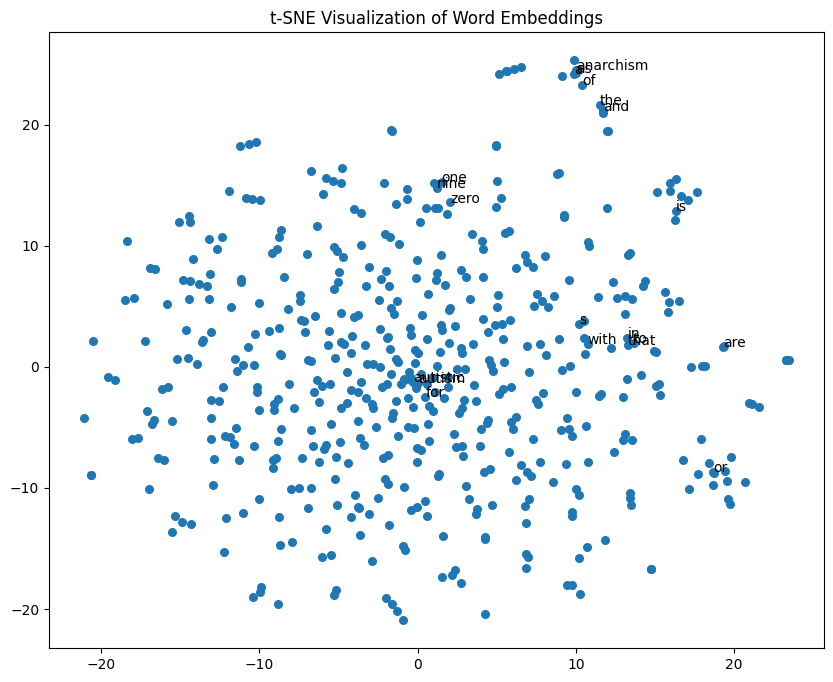

In [56]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'input_embeddings' and 'output_embeddings' are available after training
# If not, uncomment the lines below to access them
input_embeddings = model.input_embedding_layer.weight.data.cpu().numpy()
output_embeddings = model.output_embedding_layer.weight.data.cpu().numpy()
combined_embeddings = input_embeddings + output_embeddings

# Reduce dimensionality for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=15)
embeddings_2d = tsne.fit_transform(combined_embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=30)

# Annotate some of the points (adjust num_words as needed)
num_words = min(20, len(dataset.idx2word))  # Show labels for at most the first 20 words
for i in range(num_words):
    plt.annotate(dataset.idx2word[i], (embeddings_2d[i, 0], embeddings_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()
